In [1]:
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

import cnn_builder as cbuild
import config
import csv
import helper_fxns as hf
import importlib
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import pandas as pd
import random
%matplotlib inline

Using TensorFlow backend.


In [153]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(cbuild)
C = config.Config()

In [130]:
cbuild.overnight_run([C])#C_list)

IndexError: list index out of range

C_list = [config.Config(), config.Config()]
C_list[0].dims = [36,36,12]
C_list[1].dims = [24,24,12]
C_list[0].artif_dir = "E:\\imgs\\artif_imgs_3612\\"
C_list[1].artif_dir = "E:\\imgs\\artif_imgs_2412\\"
C_list[0].aug_dir = "E:\\imgs\\aug_imgs_3612_cropint\\"
C_list[1].aug_dir = "E:\\imgs\\aug_imgs_2412_cropint\\"
C_list[0].orig_dir = "E:\\imgs\\orig_imgs_3612_cropint\\"
C_list[1].orig_dir = "E:\\imgs\\orig_imgs_2412_cropint\\"

In [154]:
model = cbuild.build_cnn(C, 'adam', f=[64,128,128], dropout=[0.1,0.1], padding=['same','valid'],
                         merge_layer=0, dilation_rate=(1,1,1), kernel_size=(3,3,2), non_imaging_inputs=False, time_dist=False)#Adam(lr=.005)
model.summary(line_length=150)

______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_124 (InputLayer)                           (None, 24, 24, 12, 1)            0                                                                   
______________________________________________________________________________________________________________________________________________________
input_125 (InputLayer)                           (None, 24, 24, 12, 1)            0                                                                   
______________________________________________________________________________________________________________________________________________________
input_126 (InputLayer)                           (None, 24, 24, 12, 1)            0           

model = cbuild.run_cnn(model, C)

In [7]:
X_test, Y_test, train_generator, num_samples, _, Z = cbuild.get_cnn_data(n=4, n_art=0, run_2d=False)
Z_test, Z_train_orig = Z

In [38]:
early_stopping = EarlyStopping(monitor='loss', min_delta=0.002, patience=3)
hist = model.fit_generator(train_generator, steps_per_epoch=5, epochs=5, callbacks=[early_stopping])

Epoch 1/5
5/5 [==============================] - 17s - loss: 1.5922 - acc: 0.4083    
Epoch 2/5
5/5 [==============================] - 9s - loss: 1.4402 - acc: 0.4917     
Epoch 3/5
5/5 [==============================] - 9s - loss: 1.3701 - acc: 0.4833     
Epoch 4/5
5/5 [==============================] - 9s - loss: 1.2188 - acc: 0.5833     
Epoch 5/5
5/5 [==============================] - 9s - loss: 1.2164 - acc: 0.5333     


model_num=1
model.save('E:\\models\\models_%d.hdf5' % model_num)
model_num += 1

run_stats = pd.read_csv(C.run_stats_path)

In [13]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)
small_voi_df = pd.read_csv(C.small_voi_path)

a = run_stats.loc[:,['y_true','y_pred_raw']]
a = a.dropna()
b = a.iloc[0]['y_pred_raw']
b = hf.str_to_lists(b)

In [10]:
C.output_img_dir = "Z:\\OUTPUT\\1-1"
C.classes_to_include

['hcc', 'cholangio', 'colorectal', 'cyst', 'hemangioma', 'fnh']

In [71]:
#plot_with_bbox(fn_list[2], cls_mapping[wrong_guesses[2]])
Y_pred = model.predict(X_test)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#save_output(Z_test, y_pred, y_true)

In [72]:
fn_list = fn_list + list(Z_test[~np.equal(y_pred, y_true)])

In [74]:
fn_list = fn_list + list(Z_train_orig[~np.equal(y_pred, y_true)])
fn_list = fn_list + list(Z_train_orig[~np.equal(y_pred, y_true)])

In [75]:
fn_x_list = [x+"("+str(voi_df_art[voi_df_art["id"] == x[:-4]]["x1"].values[0])+")" for x in fn_list]

In [76]:
unique, counts = np.unique(fn_x_list, return_counts=True)

In [ ]:
dict(zip(unique, counts))

In [73]:
Y_pred = model.predict(X_train_orig)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_train_orig])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#save_output(Z_train_orig, y_pred, y_true)#, save_dir=C.output_img_dir+"\\training")

In [33]:
accuracy_score(y_true, y_pred)

0.81818181818181823

In [34]:
y_true_simp, y_pred_simp, _ = condense_cm(y_true, y_pred, C.classes_to_include)

In [35]:
accuracy_score(y_true_simp, y_pred_simp)

0.875

-3.0 3.0 -1.09655824525


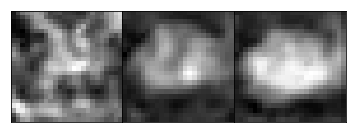

In [16]:
a=next(train_generator)
imgtrain = a[0][0][0]
img = imgtrain
hf.plot_section_auto_1ch(imgtrain[:,:,:,0])
print(np.amin(img), np.amax(img), np.mean(img))

-1.0 1.0 0.166082977132


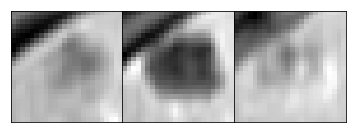

In [25]:
imgtest = X_train[0][1]
img = imgtest
print(np.amin(img), np.amax(img), np.mean(img))
hf.plot_section_auto_1ch(imgtest[:,:,:,0])

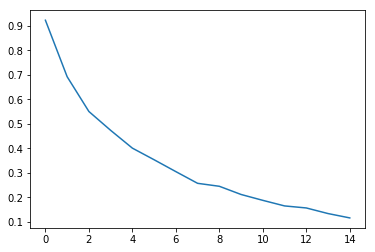

In [369]:
plt.plot(hist.history['loss'])

In [5]:
import keras.models

In [7]:
model = keras.models.load_model(C.model_save_dir+"models_8.hdf5")

In [8]:
w = model.get_weights()

In [11]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_64 (InputLayer)            (None, 24, 24, 12, 1) 0                                            
____________________________________________________________________________________________________
input_65 (InputLayer)            (None, 24, 24, 12, 1) 0                                            
____________________________________________________________________________________________________
input_66 (InputLayer)            (None, 24, 24, 12, 1) 0                                            
____________________________________________________________________________________________________
conv3d_106 (Conv3D)              (None, 24, 24, 12, 64 1216        input_64[0][0]                   
___________________________________________________________________________________________

In [29]:
len(w)

42

0-5: first conv layers


In [28]:
len(model.weights)

42

In [40]:
model.layers[16:27]

In [41]:
clayer = model.layers[20]

In [47]:
clayer.name

'conv3d_110'

In [45]:
clayer.get_weights()[0].shape

(3, 3, 2, 128, 128)

In [51]:
import numpy as np

# we start from a gray image with some noise
input_img_data = np.random.random((1, 3, 12, 24, 24)) * 20 + 128.
# run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

NameError: name 'iterate' is not defined

In [56]:
input_img

<tf.Tensor 'input_64:0' shape=(?, 24, 24, 12, 1) dtype=float32>

In [76]:
K.placeholder((None, 24, 24, 12, 3))

<tf.Tensor 'Placeholder_102:0' shape=(?, 24, 24, 12, 3) dtype=float32>

In [80]:
import time
# dimensions of the generated pictures for each filter.
img_width = 24
img_height = 24
img_slices = 12

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'conv3d_110'

# util function to convert a tensor into a valid image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 3, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# build the VGG16 network with ImageNet weights
#model = vgg16.VGG16(weights='imagenet', include_top=False)
#print('Model loaded.')

#model.summary()

# this is the placeholder for the input images
input_img = model.input#K.stack(model.input,axis=4)

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters = []
for filter_index in range(30):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height, img_slices))
    else:
        input_img_data = np.random.random((1, img_width, img_height, img_slices, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

# we will stich the best 64 filters on a 8 x 8 grid.
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img[:,:,img.shape[2]//2,:]

# save the result to disk
imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

Processing filter 0


TypeError: unhashable type: 'list'

In [ ]:
fig = plt.imshow(img, cmap='gray')

In [33]:
for layer in model.layers:
    print(layer.get_config())#, layer.get_weights())

{'dtype': 'float32', 'name': 'input_64', 'sparse': False, 'batch_input_shape': (None, 24, 24, 12, 1)}
{'dtype': 'float32', 'name': 'input_65', 'sparse': False, 'batch_input_shape': (None, 24, 24, 12, 1)}
{'dtype': 'float32', 'name': 'input_66', 'sparse': False, 'batch_input_shape': (None, 24, 24, 12, 1)}
{'strides': (1, 1, 1), 'bias_initializer': {'config': {}, 'class_name': 'Zeros'}, 'kernel_regularizer': None, 'dilation_rate': (1, 1, 1), 'trainable': True, 'activation': 'linear', 'padding': 'same', 'filters': 64, 'bias_regularizer': None, 'use_bias': True, 'kernel_constraint': None, 'bias_constraint': None, 'kernel_initializer': {'config': {'seed': None, 'distribution': 'uniform', 'mode': 'fan_avg', 'scale': 1.0}, 'class_name': 'VarianceScaling'}, 'name': 'conv3d_106', 'kernel_size': (3, 3, 2), 'activity_regularizer': None, 'data_format': 'channels_last'}
{'strides': (1, 1, 1), 'bias_initializer': {'config': {}, 'class_name': 'Zeros'}, 'kernel_regularizer': None, 'dilation_rate': (1,

In [32]:
w[18]

array([[[[[ -1.23126432e-01,   8.91563296e-02,   1.25984848e-01, ...,
             1.76226541e-01,   7.58610480e-03,  -1.09013714e-01],
          [ -1.68650709e-02,   1.31507114e-01,  -1.51953474e-02, ...,
             1.85953528e-02,  -4.92657125e-02,  -2.04637676e-01],
          [ -1.82801723e-01,   5.97427133e-03,  -7.44231567e-02, ...,
             2.23880097e-01,  -1.34945856e-02,  -4.60588038e-02],
          ..., 
          [  5.74414842e-02,  -6.29754364e-02,   7.46337464e-03, ...,
            -8.40481464e-03,   6.41438831e-03,   1.81427039e-02],
          [ -3.14454315e-03,   7.90632591e-02,  -1.36458516e-01, ...,
            -5.29522933e-02,  -1.53622255e-01,   1.41329035e-01],
          [  1.88589305e-01,   1.13613024e-01,  -9.56826955e-02, ...,
             4.29467484e-02,  -2.90436354e-02,   7.35547394e-02]],

         [[ -2.34330118e-01,   1.91328555e-01,   1.49007723e-01, ...,
             1.35848120e-01,  -1.00585639e-01,   2.63163745e-02],
          [ -1.05722763e-01,  

In [30]:
w[16].size + w[7].size

128